In [5]:
lines = []
with open('europarl_raw/train.en', 'r') as file:
    # Read the file line by line
    for line in file:
        # Process each line as needed
        lines.append(line.strip()) 

In [6]:
indexes= [6227,  447, 7952, 4216, 4228, 9892, 7145, 9924, 1954, 2850]

for index in indexes:
    print(lines[index], len(lines[index].split()))

it fell . 3
what an explanation ! 4
i voted against . 4
nothing has happened . 4
i agree . 3
every day counts . 4
i am voting in favour . is there anyone who will be against ? 14
the process of introducing these products into the market is stagnating . 12
arms exports are killing people all over the world . 10
there are four points i would make here . 9


In [7]:
!pip install seaborn

In [22]:
import os
import argparse
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch.serialization import default_restore_location

from seq2seq import models, utils
from seq2seq.data.dictionary import Dictionary
from seq2seq.data.dataset import Seq2SeqDataset, BatchSampler

import argparse

dict_data = {'data': 'europarl_prepared', 'source_lang': 'de', 'target_lang': 'en', 'max_tokens': None, 'batch_size': 10, 'train_on_tiny': False, 'arch': 'lstm', 'max_epoch': 100, 'clip_norm': 4.0, 'lr': 0.0003, 'patience': 10, 'log_file': None, 'save_dir': 'checkpoints', 'restore_file': 'None', 'save_interval': 1, 'no_save': False, 'epoch_checkpoints': False, 'decoder_use_lexical_model': 'True', 'encoder_embed_dim': 64, 'encoder_embed_path': None, 'encoder_hidden_size': 64, 'encoder_num_layers': 1, 'encoder_bidirectional': 'True', 'encoder_dropout_in': 0.25, 'encoder_dropout_out': 0.25, 'decoder_embed_dim': 64, 'decoder_embed_path': None, 'decoder_hidden_size': 128, 'decoder_num_layers': 1, 'decoder_dropout_in': 0.25, 'decoder_dropout_out': 0.25, 'decoder_use_attention': 'True', 'device_id': 0}
args = argparse.Namespace(**dict_data)


data='europarl_prepared'
torch.manual_seed(42)
state_dict = torch.load('../lexical model checkpoints/checkpoint_lexical.pt')
source_lang, target_lang = 'de', 'en'
src_dict = Dictionary.load(os.path.join(data, 'dict.{:s}'.format(source_lang)))
print('Loaded a source dictionary ({:s}) with {:d} words'.format(source_lang, len(src_dict)))
tgt_dict = Dictionary.load(os.path.join(data, 'dict.{:s}'.format(target_lang)))
print('Loaded a target dictionary ({:s}) with {:d} words'.format(target_lang, len(tgt_dict)))

    # Load dataset
test_dataset = Seq2SeqDataset(
    src_file=os.path.join(data, 'test.{:s}'.format(source_lang)),
    tgt_file=os.path.join(data, 'test.{:s}'.format(target_lang)),
    src_dict=src_dict, tgt_dict=tgt_dict)

vis_loader = torch.utils.data.DataLoader(test_dataset, num_workers=1, collate_fn=test_dataset.collater,
                                             batch_sampler=BatchSampler(test_dataset, None, 1, 1, 0, shuffle=False,
                                                                        seed=42))
    # Build model and optimization criterion
model = models.build_model(args, src_dict, tgt_dict)
model.load_state_dict(state_dict['model'])
print('Loaded a model from checkpoint {:s}'.format('checkpoint'))


Loaded a source dictionary (de) with 5047 words
Loaded a target dictionary (en) with 4420 words
Loaded a model from checkpoint checkpoint


In [23]:
attn_records = []

for i, sample in enumerate(vis_loader):
    # Only visualize the first 10 sentence pairs
    if i in [92, 295, 164]:
        print(sample['src_tokens'], sample['src_lengths'])
        if len(sample) == 0:
            continue

        # Perform forward pass
        output, attn_weights = model(sample['src_tokens'], sample['src_lengths'], sample['tgt_inputs'])
        attn_records.append((sample, attn_weights))

tensor([[ 278,   63,   18,   38, 1732,    4,  315,    3,    1]])
tensor([[  57,   91, 1201,  332,   36,    4,    7,  197, 1883,    3,    1]])
tensor([[  12, 1646,    6, 1291,    2,    7,    9,   23,    2,  388, 2675,    3,
            1]])


In [10]:
attn_records

[({'id': tensor([279]),
   'src_tokens': tensor([[ 278,   63,   18,   38, 1732,    4,  315,    3,    1]]),
   'src_lengths': tensor([9]),
   'tgt_tokens': tensor([[ 393,   26,  143, 1474,    6,   59,  124,    3,    1]]),
   'tgt_inputs': tensor([[   1,  393,   26,  143, 1474,    6,   59,  124,    3]]),
   'num_tokens': 9},
  tensor([[[0.7273, 0.1063, 0.0393, 0.0476, 0.0265, 0.0063, 0.0293, 0.0078,
            0.0096],
           [0.2427, 0.2061, 0.2796, 0.1527, 0.0354, 0.0046, 0.0223, 0.0088,
            0.0479],
           [0.1583, 0.7213, 0.0264, 0.0327, 0.0200, 0.0157, 0.0134, 0.0066,
            0.0057],
           [0.0932, 0.0928, 0.0345, 0.0917, 0.5319, 0.0687, 0.0731, 0.0070,
            0.0071],
           [0.0538, 0.1227, 0.0442, 0.2238, 0.1726, 0.1082, 0.2055, 0.0521,
            0.0171],
           [0.0347, 0.0251, 0.0318, 0.2973, 0.1793, 0.0840, 0.3074, 0.0231,
            0.0174],
           [0.0792, 0.0654, 0.0205, 0.0649, 0.0866, 0.2091, 0.3798, 0.0827,
            0.011

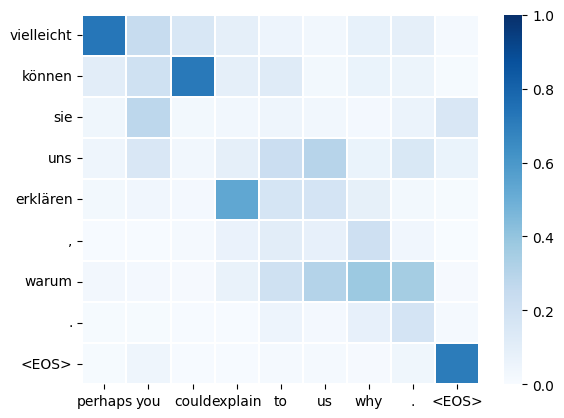

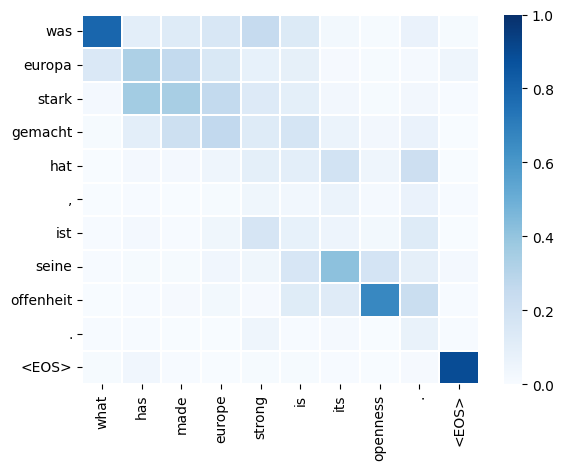

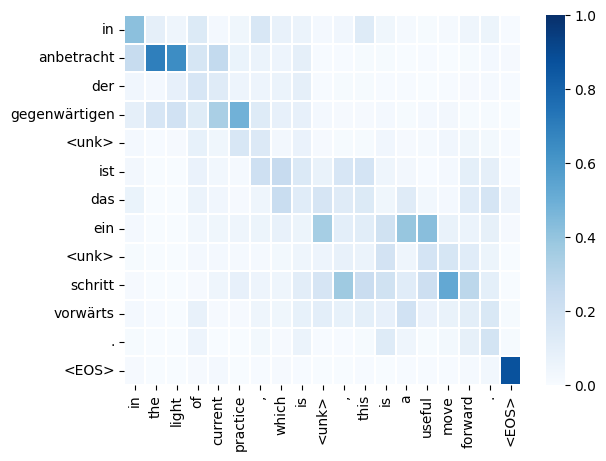

<Figure size 640x480 with 0 Axes>

In [11]:
for record_id, record in enumerate(attn_records):
    # Unpack
    sample, attn_map = record
    src_ids = utils.strip_pad(sample['src_tokens'].data, tgt_dict.pad_idx)
    tgt_ids = utils.strip_pad(sample['tgt_inputs'].data, tgt_dict.pad_idx)
    # Convert indices into word tokens
    src_str = src_dict.string(src_ids).split(' ') + ['<EOS>']
    tgt_str = tgt_dict.string(tgt_ids).split(' ') + ['<EOS>']

    # Generate heat-maps
    attn_map = attn_map.squeeze(dim=0).transpose(1, 0).detach().cpu().numpy()

    attn_df = pd.DataFrame(attn_map,
                            index=src_str,
                            columns=tgt_str)

    sns.heatmap(attn_df, cmap='Blues', linewidths=0.25, vmin=0.0, vmax=1.0, xticklabels=True, yticklabels=True,
                fmt='.3f')
    plt.yticks(rotation=0)
    plt.show()
    plt.clf()
